In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import os

FILE_SUFFIX = "DP1"

print("Step 1: Loading the dataset.")
df = pd.read_csv('datasets/drug_overdose.csv')

print("Step 2: Cleaning the data and engineering features.")

df = df[df['Indicator'] == 'Number of Drug Overdose Deaths'].copy()

df.dropna(subset=['Data Value'], inplace=True)

cols_to_drop = ['State', 'Period', 'Footnote', 'Footnote Symbol',
                'Predicted Value', 'Percent Complete', 'Percent Pending Investigation']
df.drop(columns=cols_to_drop, inplace=True)

print("Step 3: Separating features (X) and target (y).")
y = df['Data Value']
X = df[['State Name', 'Year']]

print("Step 4: Identifying and preprocessing numerical and categorical columns.")
categorical_cols = ['State Name']
numeric_cols = ['Year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X).toarray()
y_scaler = StandardScaler()
y_processed = y_scaler.fit_transform(y.values.reshape(-1, 1))

os.makedirs("artifacts", exist_ok=True)

joblib.dump(preprocessor.named_transformers_['num'], f"artifacts/feature_scaler{FILE_SUFFIX}.joblib")
print(f"Saved numeric feature scaler to artifacts/feature_scaler{FILE_SUFFIX}.joblib")

joblib.dump(preprocessor.named_transformers_['cat'], f"artifacts/onehot_encoder{FILE_SUFFIX}.joblib")
print(f"Saved one-hot encoder to artifacts/onehot_encoder{FILE_SUFFIX}.joblib")

joblib.dump(y_scaler, f"artifacts/target_scaler{FILE_SUFFIX}.joblib")
print(f"Saved target scaler to artifacts/target_scaler{FILE_SUFFIX}.joblib")

print("\nStep 5: Combining and saving the cleaned data to a CSV file.")
feature_names = preprocessor.get_feature_names_out()

cleaned_df = pd.DataFrame(X_processed, columns=feature_names)
cleaned_df['scaled_data_value'] = y_processed

cleaned_df.to_csv(f'cleaned_overdose_data{FILE_SUFFIX}.csv', index=False)
print(f"File 'cleaned_overdose_data{FILE_SUFFIX}.csv' has been saved successfully.")

print("\nData preprocessing complete.")

Step 1: Loading the dataset.
Step 2: Cleaning the data and engineering features.
Step 3: Separating features (X) and target (y).
Step 4: Identifying and preprocessing numerical and categorical columns.
Saved numeric feature scaler to artifacts/feature_scalerDP1.joblib
Saved one-hot encoder to artifacts/onehot_encoderDP1.joblib
Saved target scaler to artifacts/target_scalerDP1.joblib

Step 5: Combining and saving the cleaned data to a CSV file.
File 'cleaned_overdose_dataDP1.csv' has been saved successfully.

Data preprocessing complete.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
import shap

FILE_SUFFIX = "DP1"
torch.manual_seed(42)
np.random.seed(42)

BATCH_SIZE = 256
MICROBATCH_SIZE = 16
EPOCHS = 100
NOISE_MULTIPLIER = 1.1
MAX_GRAD_NORM = 1.0
DELTA = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nStep 1: Loading the cleaned dataset.")
df = pd.read_csv(f'cleaned_overdose_data{FILE_SUFFIX}.csv')

print("Step 2: Separating features (X) and target (y).")
X = df.drop(columns='scaled_data_value').values.astype(np.float32)
y = df['scaled_data_value'].values.astype(np.float32).reshape(-1, 1)
feature_names = df.drop(columns='scaled_data_value').columns.tolist()
INPUT_DIM = X.shape[1]

print("Step 3: Splitting the data into training and testing sets.")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

print("Step 4: Building the feedforward neural network model.")
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

teacher_model = RegressionNN(INPUT_DIM).to(device)

print("Step 5: Training the model with DP-SGD.")
criterion = nn.MSELoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=1e-3)

privacy_engine = PrivacyEngine(secure_mode=False)

teacher_model, optimizer, train_loader = privacy_engine.make_private(
    module=teacher_model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=NOISE_MULTIPLIER,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Training with Noise Multiplier: {NOISE_MULTIPLIER} and Delta: {DELTA}")
final_epsilon = 0.0

for epoch in range(EPOCHS):
    teacher_model.train()
    epoch_loss = 0.0

    with BatchMemoryManager(
        data_loader=train_loader,
        optimizer=optimizer,
        max_physical_batch_size=MICROBATCH_SIZE
    ) as train_loader_managed:
        for xb, yb in train_loader_managed:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = teacher_model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    epsilon = privacy_engine.get_epsilon(DELTA)
    final_epsilon = epsilon
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Train MSE: {avg_loss:.4f}  (ε = {epsilon:.2f})")

print("\nStep 6: Evaluating the model on the test data.")
teacher_model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = teacher_model(xb).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\n" + "="*40)
print("DP-SGD TEACHER MODEL EVALUATION METRICS")
print("="*40)
all_true_np = np.array(all_true)
all_preds_np = np.array(all_preds)
test_mse = mean_squared_error(all_true_np, all_preds_np)
test_mae = mean_absolute_error(all_true_np, all_preds_np)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(all_true_np, all_preds_np)

print("--- Utility Metrics ---")
print(f"Mean Squared Error (MSE):      {test_mse:.4f}")
print(f"**Mean Absolute Error (MAE):** {test_mae:.4f}")
print(f"**Root Mean Squared Error (RMSE):** {test_rmse:.4f}")
print(f"**R-squared (R²):** {test_r2:.4f}")
print("\n--- Privacy Metrics ---")
print(f"**Noise Multiplier:** {NOISE_MULTIPLIER}")
print(f"**Epsilon (Final):** {final_epsilon:.4f}")
print(f"**Delta:** {DELTA}")
print("="*40 + "\n")

print("\nStep 7: Generating SHAP explanations using DeepExplainer.")
dp_model_unwrapped = teacher_model._module
clean_model = RegressionNN(INPUT_DIM).to(device)
clean_model.load_state_dict(dp_model_unwrapped.state_dict())
clean_model.eval()

background_size = min(100, len(X_train))
background_data = torch.tensor(
    X_train[np.random.choice(X_train.shape[0], background_size, replace=False)],
    dtype=torch.float32
).to(device)
X_explain = torch.tensor(X_test[:20], dtype=torch.float32).to(device)

explainer = shap.DeepExplainer(clean_model, background_data)
shap_values = explainer.shap_values(X_explain)

if shap_values.ndim > 1:
    shap_values = np.squeeze(shap_values, axis=-1)

mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
feature_importance = dict(zip(feature_names, mean_abs_shap))

print("\nAverage absolute SHAP values (feature importance):")
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, value in sorted_importance[:10]:
    print(f"{feature}: {value:.4f}")

print("\nStep 8: Saving model and SHAP results.")
TEACHER_SAVE_PATH = f"artifacts/dpsgd_regression_model{FILE_SUFFIX}.pt"
torch.save(dp_model_unwrapped.state_dict(), TEACHER_SAVE_PATH)
print(f"DP-SGD Teacher model saved to {TEACHER_SAVE_PATH}")

shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)
SHAP_SAVE_PATH = f'teacher_shap_importance_reg{FILE_SUFFIX}.csv' 
shap_df.to_csv(SHAP_SAVE_PATH, index=False)
print(f"SHAP feature importance saved to '{SHAP_SAVE_PATH}'.")

print("\n--- Process Complete ---")


Step 1: Loading the cleaned dataset.
Step 2: Separating features (X) and target (y).
Step 3: Splitting the data into training and testing sets.
Step 4: Building the feedforward neural network model.
Step 5: Training the model with DP-SGD.


/home/avni/venv/lib/python3.12/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/avni/venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Training with Noise Multiplier: 1.1 and Delta: 0.0001
Epoch [10/100] - Train MSE: 0.9266  (ε = 3.24)
Epoch [20/100] - Train MSE: 0.9121  (ε = 4.66)
Epoch [30/100] - Train MSE: 0.7984  (ε = 5.82)
Epoch [40/100] - Train MSE: 0.5826  (ε = 6.86)
Epoch [50/100] - Train MSE: 0.3258  (ε = 7.80)
Epoch [60/100] - Train MSE: 0.1436  (ε = 8.69)
Epoch [70/100] - Train MSE: 0.0666  (ε = 9.53)
Epoch [80/100] - Train MSE: 0.0453  (ε = 10.33)
Epoch [90/100] - Train MSE: 0.0471  (ε = 11.10)
Epoch [100/100] - Train MSE: 0.0397  (ε = 11.84)

Step 6: Evaluating the model on the test data.

DP-SGD TEACHER MODEL EVALUATION METRICS
--- Utility Metrics ---
Mean Squared Error (MSE):      0.0419
**Mean Absolute Error (MAE):** 0.0396
**Root Mean Squared Error (RMSE):** 0.2046
**R-squared (R²):** 0.9618

--- Privacy Metrics ---
**Noise Multiplier:** 1.1
**Epsilon (Final):** 11.8414
**Delta:** 0.0001


Step 7: Generating SHAP explanations using DeepExplainer.

Average absolute SHAP values (feature importance):
cat

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os

FILE_SUFFIX = "DP1" 

print("Step 1: Loading cleaned data...")

data_path = f"cleaned_overdose_data{FILE_SUFFIX}.csv" 
df = pd.read_csv(data_path)

print("Step 2: Splitting features and target...")

X = df.drop(columns=['scaled_data_value']).values.astype(np.float32)
y = df['scaled_data_value'].values.astype(np.float32)

print("Step 3: Creating train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

input_dim = X_train.shape[1]

print("Step 4: Loading trained DP-SGD model...")

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RegressionNN(input_dim).to(device)

weights_path = f"artifacts/dpsgd_regression_model{FILE_SUFFIX}.pt" 
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Trained model weights not found at {weights_path}.")

loaded_state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(loaded_state_dict)
model.eval()

def model_inversion_attack(model, target_value, input_dim, num_steps=1000, lr=0.01, lambda_reg=1e-4):
    """
    Attempt to reconstruct a plausible input vector that produces the given target_value.
    """
    model.eval()
    recon_input = torch.randn((1, input_dim), requires_grad=True, device=device)
    optimizer = optim.Adam([recon_input], lr=lr)
    loss_fn = nn.MSELoss()
    target_tensor = torch.tensor([[target_value]], dtype=torch.float32, device=device)

    for step in range(num_steps):
        optimizer.zero_grad()
        prediction = model(recon_input)
        loss = loss_fn(prediction, target_tensor)
        loss += lambda_reg * torch.norm(recon_input)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}/{num_steps} - Pred: {prediction.item():.4f} - Loss: {loss.item():.6f}")

    return recon_input.detach().cpu().numpy()

print("\nStep 5: Running Model Inversion Attack on DP-SGD model...")

known_targets = y_test[:5]

reconstructed_inputs = []
for tval in known_targets:
    print(f"\nReconstructing input for target value: {tval:.4f}")
    recon = model_inversion_attack(model, tval, input_dim)
    reconstructed_inputs.append(recon)

reconstructed_inputs = np.vstack(reconstructed_inputs)

print("\nReconstructed Feature Vectors (in scaled feature space):")
print(reconstructed_inputs)

os.makedirs("artifacts", exist_ok=True)
np.save(f"artifacts/reconstructed_inputs_dpsgd{FILE_SUFFIX}.npy", reconstructed_inputs)
print(f"\nSaved reconstructed inputs to artifacts/reconstructed_inputs_dpsgd{FILE_SUFFIX}.npy")

Step 1: Loading cleaned data...
Step 2: Splitting features and target...
Step 3: Creating train-test split...
Step 4: Loading trained DP-SGD model...

Step 5: Running Model Inversion Attack on DP-SGD model...

Reconstructing input for target value: 8.2064
Step 0/1000 - Pred: -1.3775 - Loss: 91.852692


/tmp/ipykernel_1159/1614508249.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(weights_path, map_location=device)


Step 100/1000 - Pred: 8.0201 - Loss: 0.035672
Step 200/1000 - Pred: 8.2055 - Loss: 0.000951
Step 300/1000 - Pred: 8.2064 - Loss: 0.000950
Step 400/1000 - Pred: 8.2064 - Loss: 0.000950
Step 500/1000 - Pred: 8.2064 - Loss: 0.000950
Step 600/1000 - Pred: 8.2064 - Loss: 0.000950
Step 700/1000 - Pred: 8.2064 - Loss: 0.000950
Step 800/1000 - Pred: 8.2064 - Loss: 0.000950
Step 900/1000 - Pred: 8.2064 - Loss: 0.000950

Reconstructing input for target value: -0.1112
Step 0/1000 - Pred: 7.1846 - Loss: 53.228580
Step 100/1000 - Pred: 0.6693 - Loss: 0.609911
Step 200/1000 - Pred: 0.0663 - Loss: 0.032323
Step 300/1000 - Pred: -0.0787 - Loss: 0.001890
Step 400/1000 - Pred: -0.1074 - Loss: 0.000848
Step 500/1000 - Pred: -0.1109 - Loss: 0.000834
Step 600/1000 - Pred: -0.1112 - Loss: 0.000834
Step 700/1000 - Pred: -0.1112 - Loss: 0.000834
Step 800/1000 - Pred: -0.1112 - Loss: 0.000834
Step 900/1000 - Pred: -0.1112 - Loss: 0.000834

Reconstructing input for target value: -0.2387
Step 0/1000 - Pred: -0.8

Loading original cleaned dataset...
Loading saved scalers/encoders and reconstructed inputs...
Reversing scaling to get real feature values...
Reconstructed feature values saved to artifacts/reconstructed_real_values_dpsgdDP1.csv
Showing reconstructed sensitive features (State Name, Year)...


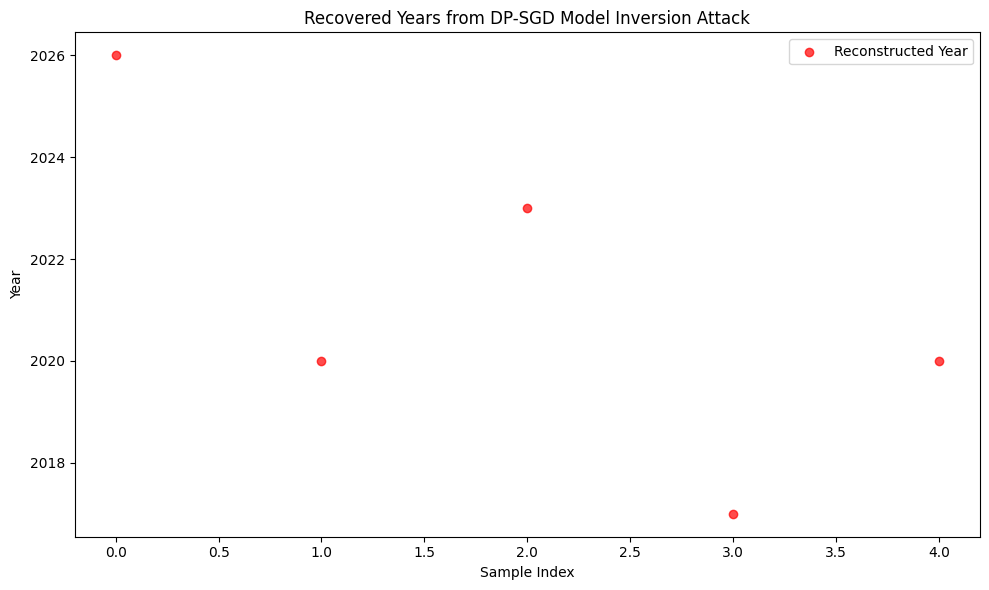


Sample of reverse-engineered sensitive data:
   Year    State Name
0  2026      Illinois
1  2020     Minnesota
2  2023   Mississippi
3  2017  South Dakota
4  2020  South Dakota

 Done — reconstructed original 'State Name' and 'Year' from DP-SGD model outputs.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib

FILE_SUFFIX = "DP1" 

print("Loading original cleaned dataset...")

data_path = f"cleaned_overdose_data{FILE_SUFFIX}.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

df = pd.read_csv(data_path)

target_col = "scaled_data_value"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found in dataset. Columns are: {df.columns.tolist()}")

X = df.drop(columns=[target_col])

print("Loading saved scalers/encoders and reconstructed inputs...")

feature_scaler_path = f"artifacts/feature_scaler{FILE_SUFFIX}.joblib"
onehot_encoder_path = f"artifacts/onehot_encoder{FILE_SUFFIX}.joblib"
recon_path = f"artifacts/reconstructed_inputs_dpsgd{FILE_SUFFIX}.npy"

for p in [feature_scaler_path, onehot_encoder_path, recon_path]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Required file not found at {p}")

feature_scaler = joblib.load(feature_scaler_path)
onehot_encoder = joblib.load(onehot_encoder_path)
recon_scaled = np.load(recon_path)

num_features = 1
cat_features = recon_scaled.shape[1] - num_features

recon_num = recon_scaled[:, :num_features]
recon_cat = recon_scaled[:, num_features:]

print("Reversing scaling to get real feature values...")

recon_years = feature_scaler.inverse_transform(recon_num).flatten()

recon_states = onehot_encoder.inverse_transform(recon_cat).flatten()

recon_df = pd.DataFrame({
    "Year": np.round(recon_years).astype(int),
    "State Name": recon_states
})

os.makedirs("artifacts", exist_ok=True)
save_path = f"artifacts/reconstructed_real_values_dpsgd{FILE_SUFFIX}.csv"
recon_df.to_csv(save_path, index=False)
print(f"Reconstructed feature values saved to {save_path}")

print("Showing reconstructed sensitive features (State Name, Year)...")

plt.figure(figsize=(10, 6))
plt.scatter(range(len(recon_df)), recon_df["Year"], c="red", label="Reconstructed Year", alpha=0.7)
plt.title("Recovered Years from DP-SGD Model Inversion Attack")
plt.xlabel("Sample Index")
plt.ylabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

print("\nSample of reverse-engineered sensitive data:")
print(recon_df.head(10))

print("\n Done — reconstructed original 'State Name' and 'Year' from DP-SGD model outputs.")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

FILE_SUFFIX = "DP1"
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TeacherNN(nn.Module):
    """The exact architecture of your trained DP-SGD RegressionNN."""
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

print("Step 1: Loading preprocessed data and splitting.")

df = pd.read_csv(f'cleaned_overdose_data{FILE_SUFFIX}.csv')
X = df.drop(columns='scaled_data_value').values.astype(np.float32)
y = df['scaled_data_value'].values.astype(np.float32).reshape(-1, 1)
input_dim = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train).to(device)

print(f"Step 2: Loading trained Teacher Model (DP-SGD model with {input_dim} features).")
teacher_model = TeacherNN(input_dim).to(device)

weights_path = f"artifacts/dpsgd_regression_model{FILE_SUFFIX}.pt" 
loaded_state_dict = torch.load(weights_path, map_location=device)
teacher_model.load_state_dict(loaded_state_dict) 
teacher_model.eval()

print("Step 3: Generating privacy-preserving Soft Targets.")
with torch.no_grad():

    Y_soft_tensor = teacher_model(X_train_tensor) 

Y_soft = Y_soft_tensor.cpu().numpy()

np.savez(f'kd_targets{FILE_SUFFIX}.npz', 
         X_train=X_train, 
         Y_train=y_train, 
         Y_soft=Y_soft, 
         X_test=X_test, 
         Y_test=y_test,
         input_dim=np.array([input_dim])
)
print(f"\nSoft targets generated and saved to kd_targets{FILE_SUFFIX}.npz")

Step 1: Loading preprocessed data and splitting.
Step 2: Loading trained Teacher Model (DP-SGD model with 55 features).
Step 3: Generating privacy-preserving Soft Targets.

Soft targets generated and saved to kd_targetsDP1.npz


/tmp/ipykernel_1159/2086920334.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(weights_path, map_location=device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import os

FILE_SUFFIX = "DP1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ALPHA = 0.9
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 100

print("Step 1: Loading data and targets.")
kd_data = np.load(f'kd_targets{FILE_SUFFIX}.npz')
X_train = kd_data['X_train']
Y_train = kd_data['Y_train']
Y_soft = kd_data['Y_soft']
X_test = kd_data['X_test']
Y_test = kd_data['Y_test']
INPUT_DIM = kd_data['input_dim'][0]

class StudentNN(nn.Module):
    """Smaller architecture for efficiency/utility advantage."""
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.net(x)

student_model = StudentNN(INPUT_DIM).to(device)

train_ds = TensorDataset(
    torch.tensor(X_train), 
    torch.tensor(Y_train), 
    torch.tensor(Y_soft)
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

def kd_loss(Y_pred, Y_hard, Y_soft, alpha=ALPHA):
    """
    Combines Soft-Target Loss and Hard-Target Loss for regression.
    """
    soft_loss = nn.MSELoss()(Y_pred, Y_soft)
    hard_loss = nn.MSELoss()(Y_pred, Y_hard)
    return alpha * soft_loss + (1.0 - alpha) * hard_loss

print(f"Step 4: Training Student Model (epochs={EPOCHS}, alpha={ALPHA})...")
optimizer = optim.Adam(student_model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    student_model.train()
    epoch_loss = 0.0
    for xb, Y_hard_batch, Y_soft_batch in train_loader:
        xb, Y_hard_batch, Y_soft_batch = (
            xb.to(device), 
            Y_hard_batch.to(device), 
            Y_soft_batch.to(device)
        )
        optimizer.zero_grad()
        Y_pred = student_model(xb)
        loss = kd_loss(Y_pred, Y_hard_batch, Y_soft_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {epoch_loss/len(X_train):.4f}")

student_model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb_test, Y_test_batch in test_loader:
        preds = student_model(xb_test.to(device)).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(Y_test_batch.numpy())

print("\n" + "="*40)
print("KD STUDENT MODEL EVALUATION METRICS")
print("="*40)
all_true_np = np.array(all_true)
all_preds_np = np.array(all_preds)
test_mse = mean_squared_error(all_true_np, all_preds_np)
test_mae = mean_absolute_error(all_true_np, all_preds_np)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(all_true_np, all_preds_np)

print("--- Utility Metrics ---")
print(f"Mean Squared Error (MSE):      {test_mse:.4f}")
print(f"**Mean Absolute Error (MAE):** {test_mae:.4f}")
print(f"**Root Mean Squared Error (RMSE):** {test_rmse:.4f}")
print(f"**R-squared (R²):** {test_r2:.4f}")
print("\n--- Privacy Metrics ---")
print("**Epsilon:** Not Applicable (N/A) - Privacy is inherited from the teacher, not directly measured.")
print("**Delta:** Not Applicable (N/A)")
print("="*40 + "\n")


os.makedirs("artifacts", exist_ok=True)

STUDENT_SAVE_PATH = f"artifacts/kd_student_model{FILE_SUFFIX}.pt" 
torch.save(student_model.state_dict(), STUDENT_SAVE_PATH)
print(f"\n KD Student model trained and saved to {STUDENT_SAVE_PATH}")

Step 1: Loading data and targets.
Step 4: Training Student Model (epochs=100, alpha=0.9)...
Epoch [10/100] - Train Loss: 0.0512
Epoch [20/100] - Train Loss: 0.0052
Epoch [30/100] - Train Loss: 0.0042
Epoch [40/100] - Train Loss: 0.0039
Epoch [50/100] - Train Loss: 0.0039
Epoch [60/100] - Train Loss: 0.0038
Epoch [70/100] - Train Loss: 0.0038
Epoch [80/100] - Train Loss: 0.0038
Epoch [90/100] - Train Loss: 0.0038
Epoch [100/100] - Train Loss: 0.0038

 📊 KD STUDENT MODEL EVALUATION METRICS
--- Utility Metrics ---
Mean Squared Error (MSE):      0.0362
**Mean Absolute Error (MAE):** 0.0439
**Root Mean Squared Error (RMSE):** 0.1901
**R-squared (R²):** 0.9670

--- Privacy Metrics ---
**Epsilon:** Not Applicable (N/A) - Privacy is inherited from the teacher, not directly measured.
**Delta:** Not Applicable (N/A)


 KD Student model trained and saved to artifacts/kd_student_modelDP1.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shap
import os
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

FILE_SUFFIX = "DP1" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("artifacts", exist_ok=True)

print("Step 1: Loading data and trained Student Model.")

kd_data = np.load(f'kd_targets{FILE_SUFFIX}.npz')
X_test = kd_data['X_test']
Y_test = kd_data['Y_test']
X_train = kd_data['X_train']
INPUT_DIM = kd_data['input_dim'][0]
feature_names = pd.read_csv(f'cleaned_overdose_data{FILE_SUFFIX}.csv').drop(columns='scaled_data_value').columns.tolist()

class StudentNN(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.net(x)

student_model = StudentNN(INPUT_DIM).to(device)

student_model.load_state_dict(torch.load(f"artifacts/kd_student_model{FILE_SUFFIX}.pt", map_location=device))
student_model.eval()

print("\nStep 2: Checking Explainability Advantage (SHAP Stability).")
background_size = min(100, len(X_train))
background_data = torch.tensor(
    X_train[np.random.choice(X_train.shape[0], background_size, replace=False)],
    dtype=torch.float32
).to(device)
X_explain = torch.tensor(X_test[:20], dtype=torch.float32).to(device)

explainer = shap.DeepExplainer(student_model, background_data)
shap_values = explainer.shap_values(X_explain)
if isinstance(shap_values, list):
    shap_values = shap_values[0]
if shap_values.ndim > 2:
    shap_values = np.squeeze(shap_values)

mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
feature_importance = dict(zip(feature_names, mean_abs_shap))

print("**Average absolute SHAP values (feature importance) for KD Student Model:**")
student_shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

teacher_shap_df = pd.read_csv(f'teacher_shap_importance_reg{FILE_SUFFIX}.csv') 
print(f"\nTop 5 features (KD Student):")
print(student_shap_df.head())
print(f"\nTop 5 features (DP-SGD Teacher):")
print(teacher_shap_df.head())
print("  (Compare to see if knowledge transfer was successful)")

student_shap_df.to_csv(f'student_shap_importance_reg{FILE_SUFFIX}.csv', index=False)
print(f"\nSaved Student SHAP feature importance to 'student_shap_importance_reg{FILE_SUFFIX}.csv'.")

Step 1: Loading data and trained Student Model.

Step 2: Checking Explainability Advantage (SHAP Stability).
**Average absolute SHAP values (feature importance) for KD Student Model:**

Top 5 features (KD Student):
                          feature  mean_abs_shap
47  cat__State Name_United States       0.318738
11        cat__State Name_Georgia       0.282867
14       cat__State Name_Illinois       0.220216
20          cat__State Name_Maine       0.186586
29         cat__State Name_Nevada       0.179986

Top 5 features (DP-SGD Teacher):
                         feature  mean_abs_shap
0  cat__State Name_United States       0.428613
1                      num__Year       0.065583
2     cat__State Name_California       0.042893
3          cat__State Name_Maine       0.014346
4       cat__State Name_Nebraska       0.012190
  (Compare to see if knowledge transfer was successful)

Saved Student SHAP feature importance to 'student_shap_importance_regDP1.csv'.


/tmp/ipykernel_1159/2718877745.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load(f"artifacts/kd_student_model{FILE_SUFFIX}.pt", m

Step 1: Loading data, model, and scalers...

Step 2: Running Model Inversion Attack on KD STUDENT model...

Reconstructing input for target value: 8.2064
Step 0/1000 - Pred: 1.1703 - Loss: 49.507988


/tmp/ipykernel_1159/876319484.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load(weights_path, map_location=device))


Step 100/1000 - Pred: 8.2398 - Loss: 0.001839
Step 200/1000 - Pred: 8.2063 - Loss: 0.000725
Step 300/1000 - Pred: 8.2064 - Loss: 0.000725
Step 400/1000 - Pred: 8.2064 - Loss: 0.000725
Step 500/1000 - Pred: 8.2064 - Loss: 0.000725
Step 600/1000 - Pred: 8.2064 - Loss: 0.000725
Step 700/1000 - Pred: 8.2064 - Loss: 0.000725
Step 800/1000 - Pred: 8.2064 - Loss: 0.000725
Step 900/1000 - Pred: 8.2064 - Loss: 0.000725

Reconstructing input for target value: -0.1112
Step 0/1000 - Pred: -17.1281 - Loss: 289.575012
Step 100/1000 - Pred: -0.1245 - Loss: 0.000816
Step 200/1000 - Pred: -0.1108 - Loss: 0.000637
Step 300/1000 - Pred: -0.1112 - Loss: 0.000637
Step 400/1000 - Pred: -0.1112 - Loss: 0.000637
Step 500/1000 - Pred: -0.1112 - Loss: 0.000637
Step 600/1000 - Pred: -0.1112 - Loss: 0.000637
Step 700/1000 - Pred: -0.1112 - Loss: 0.000637
Step 800/1000 - Pred: -0.1112 - Loss: 0.000637
Step 900/1000 - Pred: -0.1112 - Loss: 0.000637

Reconstructing input for target value: -0.2387
Step 0/1000 - Pred:

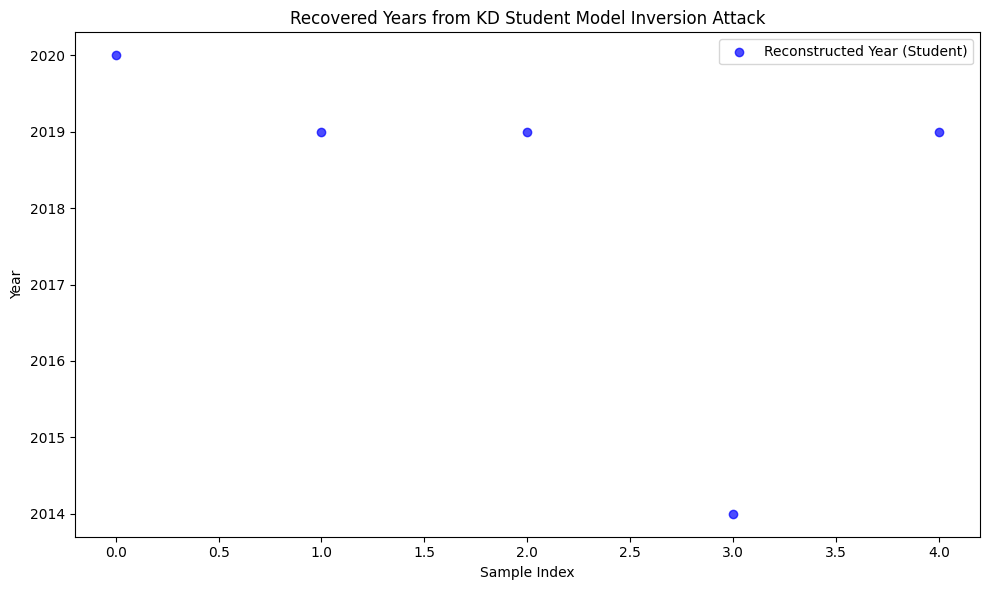


Sample of reverse-engineered sensitive data (from Student Model):
   Year     State Name
0  2020         Nevada
1  2019   South Dakota
2  2019        Wyoming
3  2014       Illinois
4  2019  New York City

 Done — reconstructed original 'State Name' and 'Year' from KD STUDENT model outputs.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib

FILE_SUFFIX = "DP1" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Step 1: Loading data, model, and scalers...")

kd_data = np.load(f'kd_targets{FILE_SUFFIX}.npz')
Y_test = kd_data['Y_test']
INPUT_DIM = kd_data['input_dim'][0]

class StudentNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.net(x)

student_model = StudentNN(INPUT_DIM).to(device)
weights_path = f"artifacts/kd_student_model{FILE_SUFFIX}.pt"
student_model.load_state_dict(torch.load(weights_path, map_location=device))
student_model.eval()

feature_scaler_path = f"artifacts/feature_scaler{FILE_SUFFIX}.joblib"
onehot_encoder_path = f"artifacts/onehot_encoder{FILE_SUFFIX}.joblib"
feature_scaler = joblib.load(feature_scaler_path)
onehot_encoder = joblib.load(onehot_encoder_path)

def model_inversion_attack(model, target_value, input_dim, num_steps=1000, lr=0.01, lambda_reg=1e-4):
    model.eval()
    recon_input = torch.randn((1, input_dim), requires_grad=True, device=device)
    optimizer = optim.Adam([recon_input], lr=lr)
    loss_fn = nn.MSELoss()
    target_tensor = torch.tensor([[target_value]], dtype=torch.float32, device=device)
    for step in range(num_steps):
        optimizer.zero_grad()
        prediction = model(recon_input)
        loss = loss_fn(prediction, target_tensor)
        loss += lambda_reg * torch.norm(recon_input)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}/{num_steps} - Pred: {prediction.item():.4f} - Loss: {loss.item():.6f}")
    return recon_input.detach().cpu().numpy()

print("\nStep 2: Running Model Inversion Attack on KD STUDENT model...")
known_targets = Y_test[:5].flatten()

reconstructed_inputs = []
for tval in known_targets:
    print(f"\nReconstructing input for target value: {tval:.4f}")
    recon = model_inversion_attack(student_model, tval, INPUT_DIM)
    reconstructed_inputs.append(recon)

reconstructed_inputs = np.vstack(reconstructed_inputs)

print("\nReconstructed Feature Vectors (in scaled feature space):")
print(reconstructed_inputs)

os.makedirs("artifacts", exist_ok=True)
np.save(f"artifacts/reconstructed_inputs_student{FILE_SUFFIX}.npy", reconstructed_inputs)
print(f"\nSaved reconstructed inputs to artifacts/reconstructed_inputs_student{FILE_SUFFIX}.npy")

print("\nStep 3: Reversing scaling to get real feature values...")
recon_scaled = reconstructed_inputs
num_features = 1
cat_features = recon_scaled.shape[1] - num_features
recon_num = recon_scaled[:, :num_features]
recon_cat = recon_scaled[:, num_features:]

recon_years = feature_scaler.inverse_transform(recon_num).flatten()
recon_states = onehot_encoder.inverse_transform(recon_cat).flatten()

recon_df = pd.DataFrame({
    "Year": np.round(recon_years).astype(int),
    "State Name": recon_states
})

save_path = f"artifacts/reconstructed_real_values_student{FILE_SUFFIX}.csv"
recon_df.to_csv(save_path, index=False)
print(f"Reconstructed feature values saved to {save_path}")

print("\nStep 4: Showing reconstructed sensitive features (State Name, Year)...")
plt.figure(figsize=(10, 6))
plt.scatter(range(len(recon_df)), recon_df["Year"], c="blue", label="Reconstructed Year (Student)", alpha=0.7)
plt.title("Recovered Years from KD Student Model Inversion Attack")
plt.xlabel("Sample Index")
plt.ylabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

print("\nSample of reverse-engineered sensitive data (from Student Model):")
print(recon_df.head(10))

print("\n Done — reconstructed original 'State Name' and 'Year' from KD STUDENT model outputs.")